Here we will have a look at raster data through an application using data from NASA's Carbon Monitoring System (CMS) program. We will focus on the small municipality of Puerto Asis in the Colombian Amazon and look at changes in Landsat-derived landuse between 2002 and 2016. Data for this notebook were downloaded from NASA'S EarthData library and hosted on CyVerse for cloud-based computing. If you would like to download the data for yourself you can access it here [https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1783](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1783). **NOTE:** A NASA EarthData account (free) is needed to download the data.

You can read more about working with raster data and the `rioxarray` library here:
> * [Earth Data Science Textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/)
> * [Rioxarray documentation](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html)

In [1]:
# Import Python libraries
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import earthpy.plot as ep
import rioxarray as rxr

In [3]:
# Define link to Colombia Municipalities shp url from 
# (https://maps.princeton.edu/catalog/tufts-colombia-municipalities-11)

col_muni_url = ('https://maps.princeton.edu/download/file'
                '/tufts-colombia-municipalities-11-shapefile.zip')

# Open data using geopandas
col_muni_gdf = gpd.read_file(col_muni_url)
col_muni_gdf

ID_ESPACIA  AREA_OFICI          ENTIDAD_TE NOM_DEPART  \
0         23189      637.49  Cabecera Municipal    CÓRDOBA   
1         23570      795.00  Cabecera Municipal    CÓRDOBA   
2         23068     1932.62  Cabecera Municipal    CÓRDOBA   
3         23580     1650.73  Cabecera Municipal    CÓRDOBA   
4         23686      472.57  Cabecera Municipal    CÓRDOBA   
...         ...         ...                 ...        ...   
1123      23675      335.03  Cabecera Municipal    CÓRDOBA   
1124      23672      210.75  Cabecera Municipal    CÓRDOBA   
1125      23168      320.42  Cabecera Municipal    CÓRDOBA   
1126      23670      212.44  Cabecera Municipal    CÓRDOBA   
1127      23182      584.90  Cabecera Municipal    CÓRDOBA   

                   NOM_MUNICI COD_DEPTO  \
0              CIÉNAGA DE ORO        23   
1                PUEBLO NUEVO        23   
2                      AYAPEL        23   
3           PUERTO LIBERTADOR        23   
4                  SAN PELAYO        23   
...                       ...       ...   
1123  SAN BERNARDO DEL VIENTO        23   
1124               SAN ANTERO        23   
1125                    CHIMÁ        23   
1126  SAN ANDRÉS DE SOTAVENTO        23   
1127                    CHINÚ        23   

                                               geometry  
0     POLYGON ((-75.71080 8.98249, -75.71119 8.98358...  
1     POLYGON ((-75.25133 8.32489, -75.25144 8.32489...  
2     POLYGON ((-75.18418 8.39828, -75.18352 8.39893...  
3     POLYGON ((-75.51257 7.94787, -75.51315 7.94683...  
4     POLYGON ((-75.71080 8.98249, -75.71024 8.98264...  
...                                                 ...  
1123  POLYGON ((-75.86320 9.42472, -75.86318 9.42231...  
1124  POLYGON ((-75.86320 9.42472, -75.86297 9.42476...  
1125  POLYGON ((-75.71080 8.98249, -75.71213 8.98212...  
1126  POLYGON ((-75.57457 9.02304, -75.57458 9.02421...  
1127  POLYGON ((-75.57457 9.02304, -75.57438 9.02306...  

[1128 rows x 7 columns]

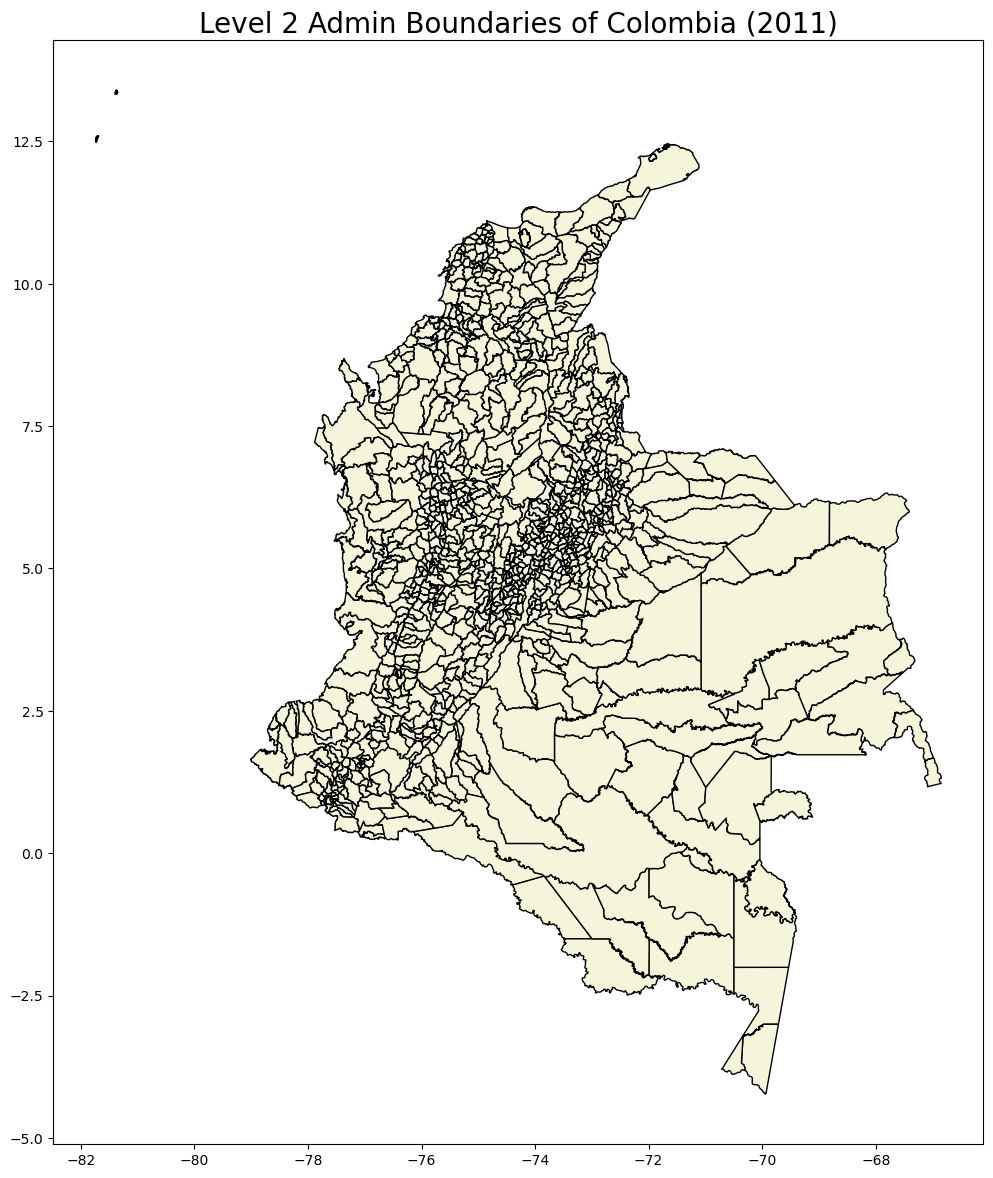

In [3]:
# Plot the geodataframe using Matplotlib
fig, ax = plt.subplots(figsize=(12,20))
col_muni_gdf.plot(ax=ax,
               edgecolor='black',
               color='beige')
plt.title('Level 2 Admin Boundaries of Colombia (2011)', fontsize=20)
plt.show()

In [4]:
# Select Putumayo Department, print the CRS, and call the data
putumayo = col_muni_gdf[col_muni_gdf["NOM_DEPART"].isin(["PUTUMAYO"])]
print("The CRS of putumayo is:\n", putumayo.crs)
putumayo

The CRS of putumayo is:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


ID_ESPACIA  AREA_OFICI          ENTIDAD_TE NOM_DEPART  \
467       86749       88.43  Cabecera Municipal   PUTUMAYO   
468       86760      339.98  Cabecera Municipal   PUTUMAYO   
469       86219      187.50  Cabecera Municipal   PUTUMAYO   
470       86755      408.74  Cabecera Municipal   PUTUMAYO   
998       86865      798.54  Cabecera Municipal   PUTUMAYO   
999       86757      386.20  Cabecera Municipal   PUTUMAYO   
1000      86320     1951.31  Cabecera Municipal   PUTUMAYO   
1001      86885     1398.80  Cabecera Municipal   PUTUMAYO   
1002      86001     1328.83          CAP. DEPTO   PUTUMAYO   
1003      86568     2800.64  Cabecera Municipal   PUTUMAYO   
1004      86569      931.95  Cabecera Municipal   PUTUMAYO   
1005      86573    10782.91  Cabecera Municipal   PUTUMAYO   
1006      86571     4538.53  Cabecera Municipal   PUTUMAYO   

                          NOM_MUNICI COD_DEPTO  \
467                         SIBUNDOY        86   
468                         SANTIAGO        86   
469                            COLÓN        86   
470                    SAN FRANCISCO        86   
998   VALLE DEL GUAMUEZ (La Hormiga)        86   
999           SAN MIGUEL (La Dorada)        86   
1000                           ORITO        86   
1001                     VILLAGARZÓN        86   
1002                           MOCOA        86   
1003                     PUERTO ASÍS        86   
1004                  PUERTO CAICEDO        86   
1005                PUERTO LEGUÍZAMO        86   
1006                   PUERTO GUZMÁN        86   

                                               geometry  
467   POLYGON ((-76.96553 1.15862, -76.96538 1.15901...  
468   POLYGON ((-77.04651 0.97891, -77.04607 0.98036...  
469   POLYGON ((-76.96553 1.15862, -76.96592 1.15895...  
470   POLYGON ((-76.85293 1.04544, -76.85349 1.04587...  
998   POLYGON ((-77.05013 0.28792, -77.05196 0.28617...  
999   POLYGON ((-77.05013 0.28792, -77.04992 0.28890...  
1000  POLYGON ((-77.07315 0.94485, -77.07294 0.94451...  
1001  POLYGON ((-77.04651 0.97891, -77.01514 0.98044...  
1002  POLYGON ((-76.87674 1.28927, -76.87881 1.29186...  
1003  POLYGON ((-76.14319 0.37627, -76.14494 0.37667...  
1004  POLYGON ((-76.76594 0.79042, -76.53859 0.79149...  
1005  POLYGON ((-75.26652 0.72525, -75.26430 0.72376...  
1006  POLYGON ((-75.26652 0.72525, -75.26792 0.72317...

<Axes: >

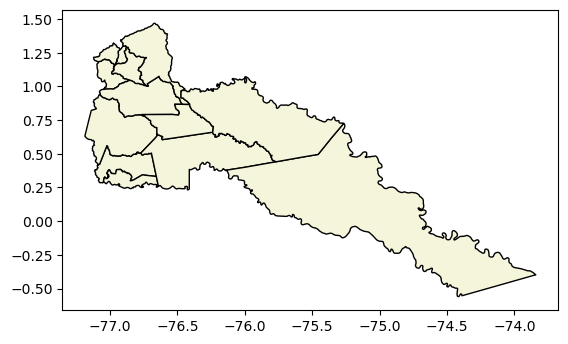

In [5]:
# Plot Putumayo using .plot()
putumayo.plot(color='beige', edgecolor='black')

In [5]:
# Select Puerto Asís from Putumayo
pr_as = putumayo[putumayo["NOM_MUNICI"].isin(["PUERTO ASÍS"])]
pr_as

ID_ESPACIA  AREA_OFICI          ENTIDAD_TE NOM_DEPART   NOM_MUNICI  \
1003      86568     2800.64  Cabecera Municipal   PUTUMAYO  PUERTO ASÍS   

     COD_DEPTO                                           geometry  
1003        86  POLYGON ((-76.14319 0.37627, -76.14494 0.37667...

In [7]:
# NOTE: the following syntax also works to select/subset data
pr_as2 = putumayo[putumayo["NOM_MUNICI"] == "PUERTO ASÍS"]
pr_as2

ID_ESPACIA  AREA_OFICI          ENTIDAD_TE NOM_DEPART   NOM_MUNICI  \
1003      86568     2800.64  Cabecera Municipal   PUTUMAYO  PUERTO ASÍS   

     COD_DEPTO                                           geometry  
1003        86  POLYGON ((-76.14319 0.37627, -76.14494 0.37667...

<Axes: >

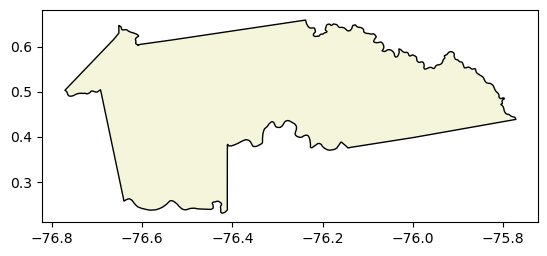

In [8]:
# Plot Puerto Asís
pr_as.plot(color='beige', edgecolor='black')

In [21]:
# Define url to 2002 raster data
raster_2001_url = ("https://data.cyverse.org/dav-anon/iplant/home/shared/"
                   "earthlab/geopark/landcover_colombian_amazon_2001.tif")

In [9]:
# Define url to 2002 raster data
raster_2002_url = ("https://data.cyverse.org/dav-anon/iplant/home/shared/"
                   "earthlab/geopark/landcover_colombian_amazon_2002.tif")

In [6]:
# Define url to 2015 raster data
raster_2015_url = ("https://data.cyverse.org/dav-anon/iplant/home/shared/"
                   "earthlab/geopark/landcover_colombian_amazon_2015.tif")

In [10]:
# Define url to 2016 raster data
raster_2016_url = ("https://data.cyverse.org/dav-anon/iplant/home/shared/"
                   "earthlab/geopark/landcover_colombian_amazon_2016.tif")

<Axes: >

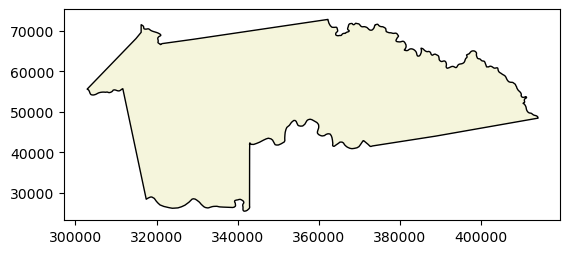

In [8]:
# Reproject Puerto Asís shp to same CRS as raster (EPSG:32618)
pr_as_32618 = pr_as.to_crs("EPSG:32618")
pr_as_32618.plot(color='beige', edgecolor='black')

In [22]:
# Open and clip the 2002 raster data to the Puerto Asis boundary using rioxarray
clipped_2001 = rxr.open_rasterio(raster_2001_url, masked=True).squeeze().rio.clip(pr_as_32618.geometry, from_disk=True)
clipped_2001

<xarray.DataArray (y: 1577, x: 3708)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 3.028e+05 3.028e+05 3.028e+05 ... 4.14e+05 4.14e+05
  * y            (y) float64 7.293e+04 7.29e+04 ... 2.568e+04 2.565e+04
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        7
    STATISTICS_MEAN:           1.3154151346901
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         0.99262652793935
    STATISTICS_VALID_PERCENT:  34.03
    scale_factor:              1.0
    add_offset:                0.0

In [12]:
# Open and clip the 2002 raster data to the Puerto Asis boundary using rioxarray
clipped_2002 = rxr.open_rasterio(raster_2002_url, masked=True).squeeze().rio.clip(pr_as_32618.geometry, from_disk=True)
clipped_2002

<xarray.DataArray (y: 1577, x: 3708)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 3.028e+05 3.028e+05 3.028e+05 ... 4.14e+05 4.14e+05
  * y            (y) float64 7.293e+04 7.29e+04 ... 2.568e+04 2.565e+04
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        7
    STATISTICS_MEAN:           1.3176634733616
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         0.99581730881901
    STATISTICS_VALID_PERCENT:  34.03
    scale_factor:              1.0
    add_offset:                0.0

In [13]:
# Check CRS of the raster data
clipped_2002.rio.crs

CRS.from_epsg(32618)

In [9]:
# Open and clip the 2015 raster data to the Puerto Asis boundary using rioxarray
clipped_2015 = rxr.open_rasterio(raster_2015_url, masked=True).squeeze().rio.clip(pr_as_32618.geometry, from_disk=True)
clipped_2015

<xarray.DataArray (y: 1577, x: 3708)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 3.028e+05 3.028e+05 3.028e+05 ... 4.14e+05 4.14e+05
  * y            (y) float64 7.293e+04 7.29e+04 ... 2.568e+04 2.565e+04
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        7
    STATISTICS_MEAN:           1.3360364719889
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         1.0324194534939
    STATISTICS_VALID_PERCENT:  34.03
    scale_factor:              1.0
    add_offset:                0.0

In [14]:
# Open and clip the 2016 raster data to the Puerto Asis boundary using rioxarray
clipped_2016 = rxr.open_rasterio(raster_2016_url, masked=True).squeeze().rio.clip(pr_as_32618.geometry, from_disk=True)
clipped_2016

<xarray.DataArray (y: 1577, x: 3708)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 3.028e+05 3.028e+05 3.028e+05 ... 4.14e+05 4.14e+05
  * y            (y) float64 7.293e+04 7.29e+04 ... 2.568e+04 2.565e+04
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        7
    STATISTICS_MEAN:           1.3297671847732
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         1.0287005111847
    STATISTICS_VALID_PERCENT:  34.03
    scale_factor:              1.0
    add_offset:                0.0

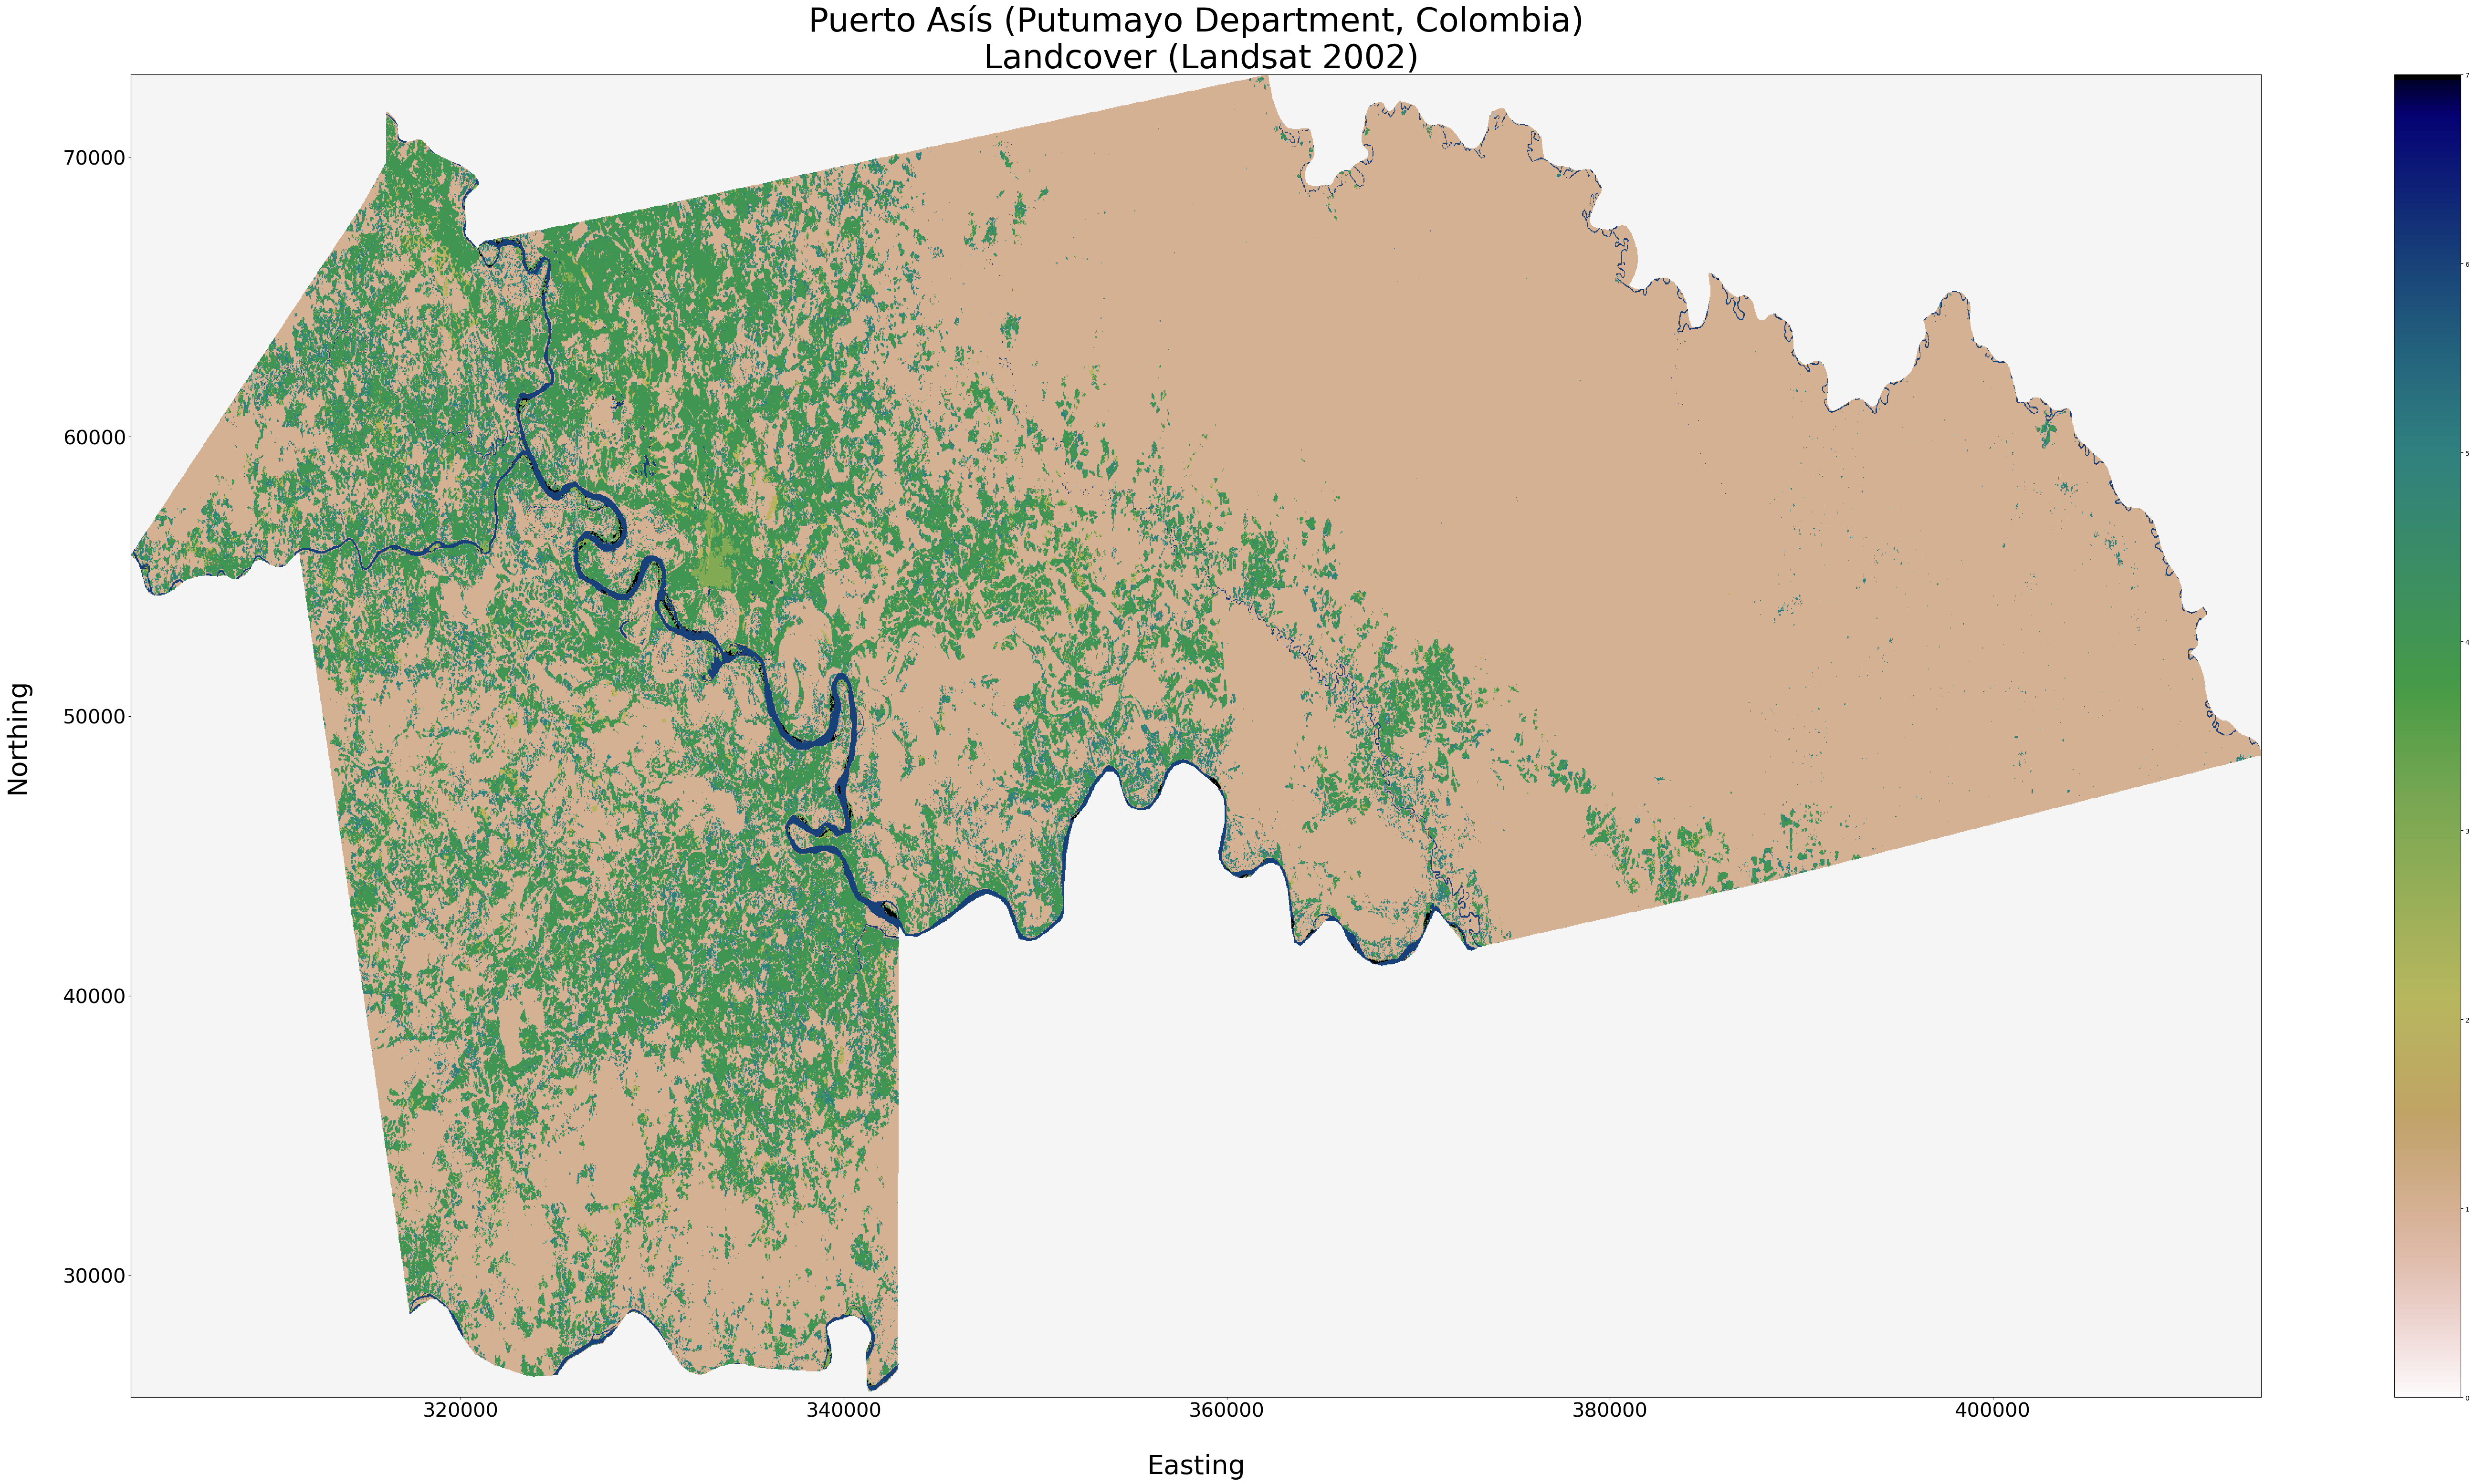

In [15]:
# Plot the raster clipped to Florencia (2002)
fig, ax = plt.subplots(figsize=(72,36))
clipped_2002.plot(ax=ax,
                          #alpha=0.8,
                          add_colorbar=True, 
                          cmap='gist_earth_r')

plt.title("Puerto Asís (Putumayo Department, Colombia)\n Landcover (Landsat 2002)",fontsize=50)
plt.xlabel("\nEasting", fontsize=40)
plt.ylabel("Northing\n", fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_facecolor("whitesmoke")
#ax.annotate('2001', xy=(380000, 30000), size=160)
plt.show()

In [18]:
# Customizing the cmap (ChatGPT)
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# NOTE: Colors and landuses from the CMS User Guide: 
# https://daac.ornl.gov/CMS/guides/Landcover_Colombian_Amazon.html

cms_colors = ['black', 
              'forestgreen', 
              'orange',
              'purple',
              'darkgoldenrod',
              'limegreen',
              'tab:blue',
              'yellow']

cms_cmap = ListedColormap(cms_colors)

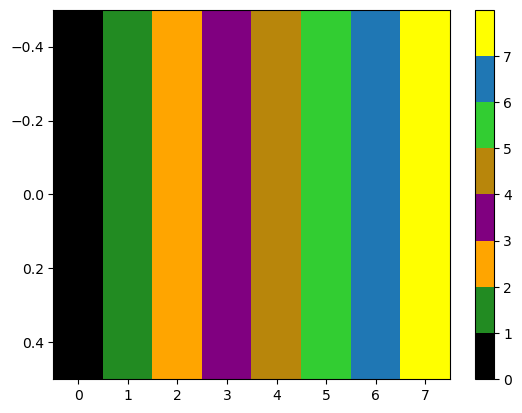

In [16]:
# Create a dummy array to map colors to
dummy_data = np.arange(8).reshape(1, -1)

# Plot the colorbar
plt.imshow(dummy_data, cmap=cms_cmap, aspect='auto', vmin=0, vmax=8)
plt.colorbar(ticks=np.arange(8))
plt.show()

In [17]:
# Create custom labels ()

# Define labels
landuse_labels = ["Unclassified",
                  "Forest",
                  "Natural Grassland",
                  "Urban",
                  "Pasture",
                  "Secondary Forest",
                  "Water",
                  "Highly Reflective Surface"]

# Define bins
class_bins = [0,1,2,3,4,5,6,7,10]

# Define norm
norm = BoundaryNorm(class_bins,
                    len(cms_colors))

In [19]:
# Creating the legend elements

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='black', lw=18, label='Unclassified',),
                   Line2D([0], [0], color='forestgreen', lw=18, label='Forest'),
                   Line2D([0], [0], color='orange', lw=18, label='Natural Grassland'),
                   Line2D([0], [0], color='purple', lw=18, label='Urban'),
                   Line2D([0], [0], color='darkgoldenrod', lw=18, label='Pasture'),
                   Line2D([0], [0], color='limegreen', lw=18, label='Secondary Forest'),
                   Line2D([0], [0], color='tab:blue', lw=18, label='Water'),
                   Line2D([0], [0], color='yellow', lw=18, label='Highly Reflective Surface')]


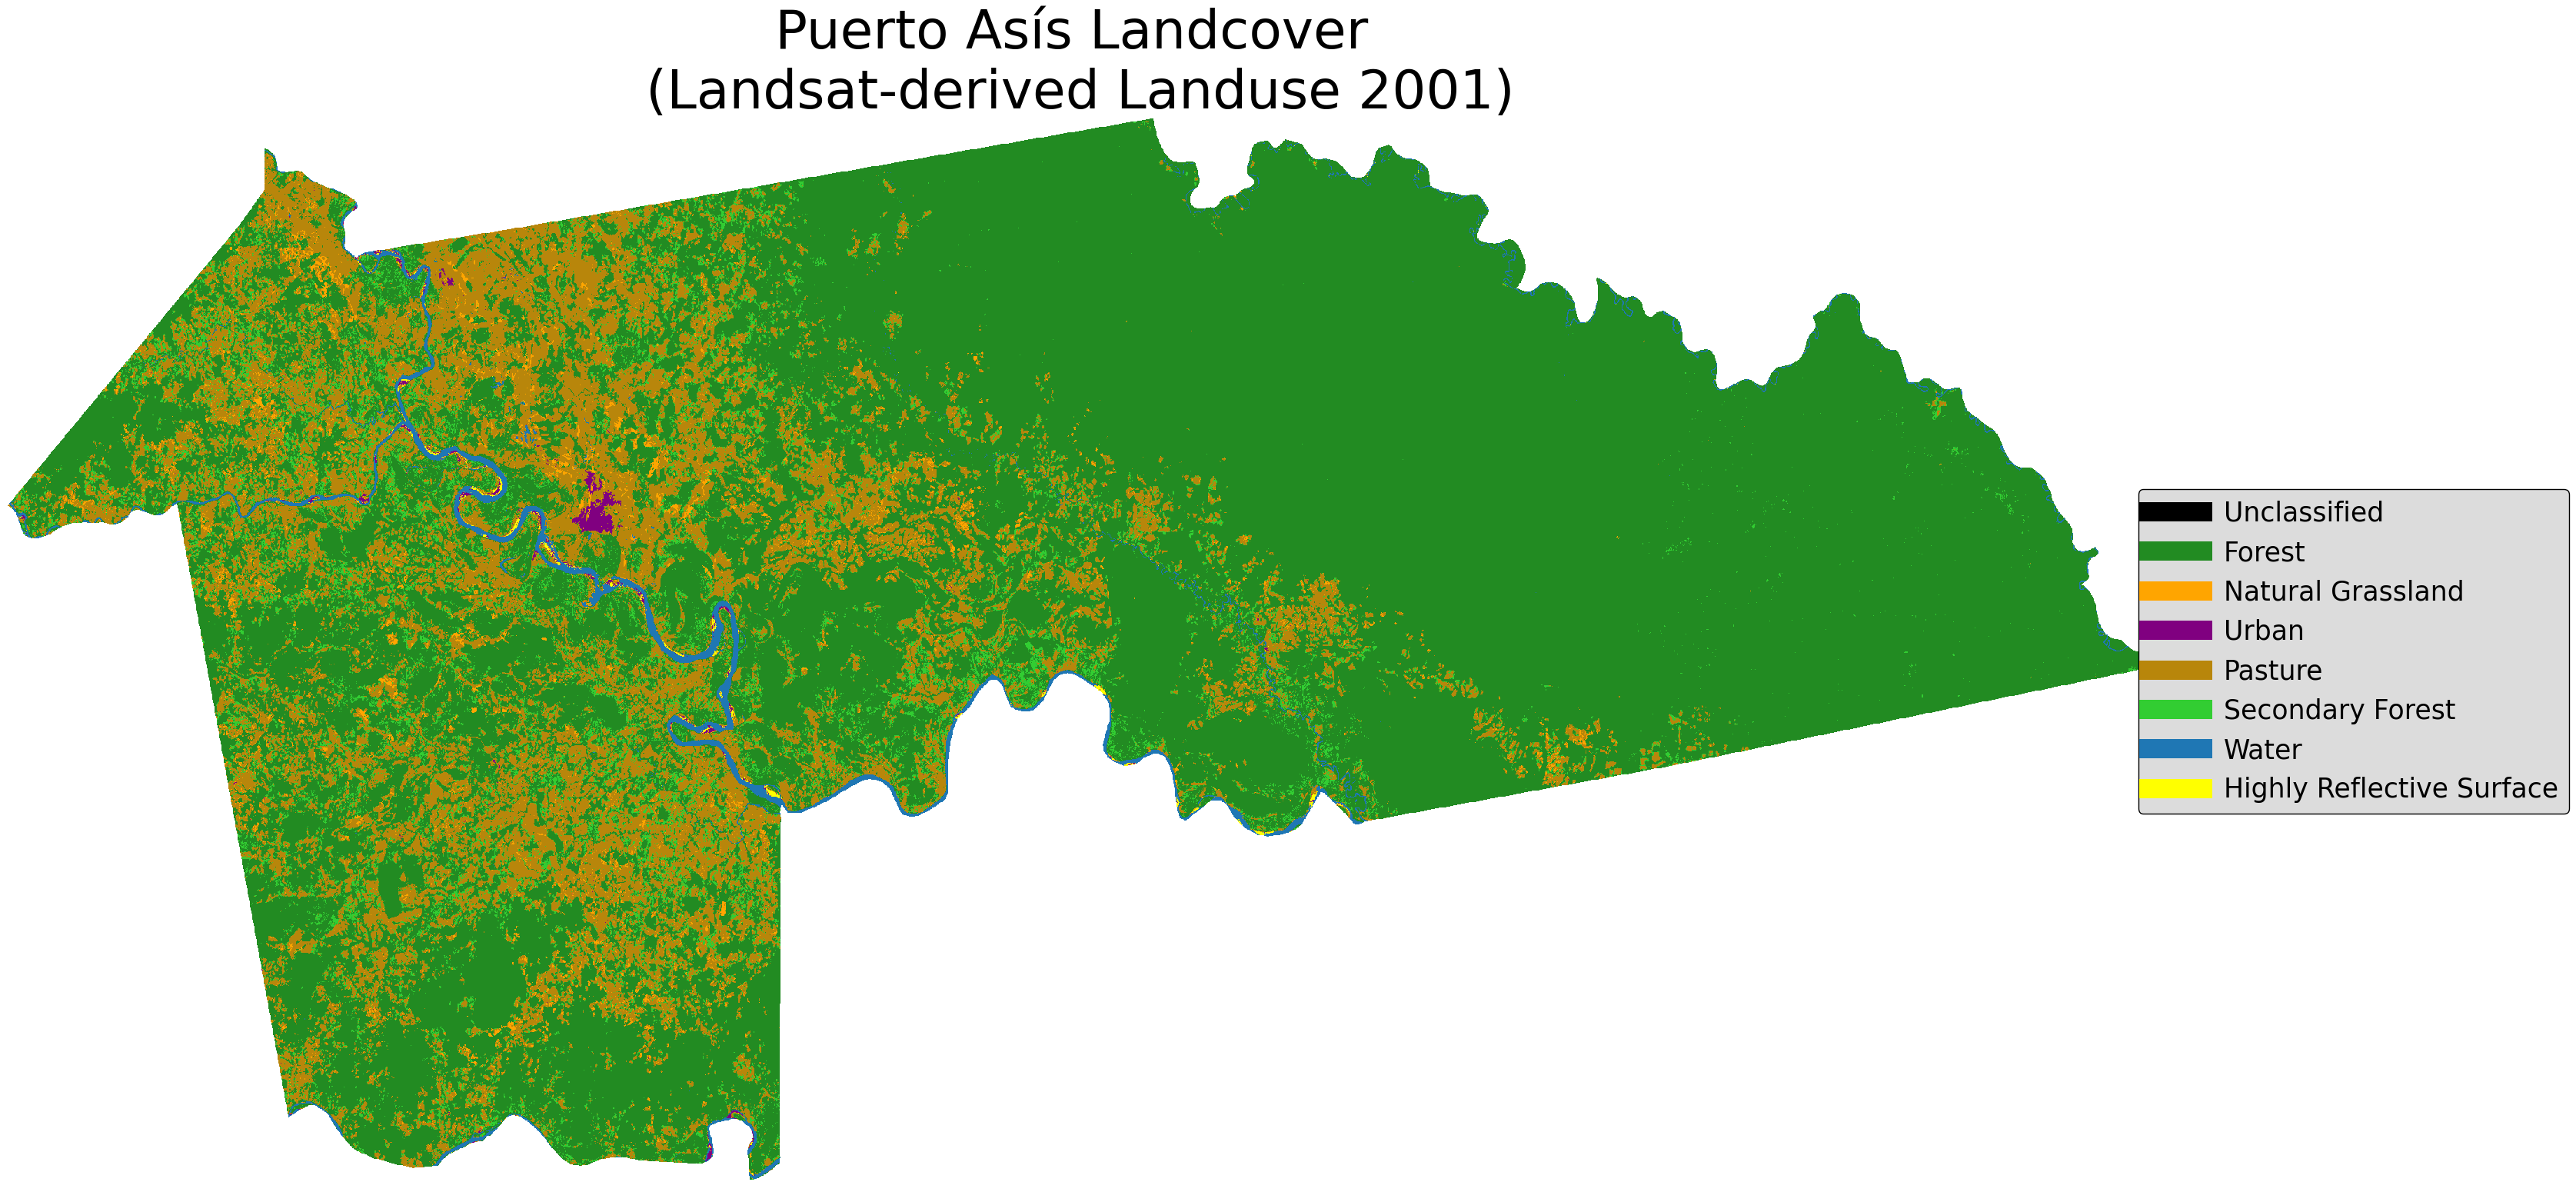

In [23]:
# Plot the raster clipped to Puerto Asís (2001)

fig, ax = plt.subplots(figsize=(36,18))

clipped_2001.where(clipped_2001!=clipped_2001.rio.nodata).plot(
    ax=ax,
    add_colorbar=False,
    cmap=cms_cmap,
    norm=norm)
plt.title("Puerto Asís Landcover \n(Landsat-derived Landuse 2001)",fontsize=50)

ax.axis('off')

ax.legend(handles=legend_elements,
          loc='right',
          fontsize='25',
          facecolor='gainsboro',
          edgecolor='black',
          framealpha=1.0,
          bbox_to_anchor=(1.2, 0.5))

plt.show()

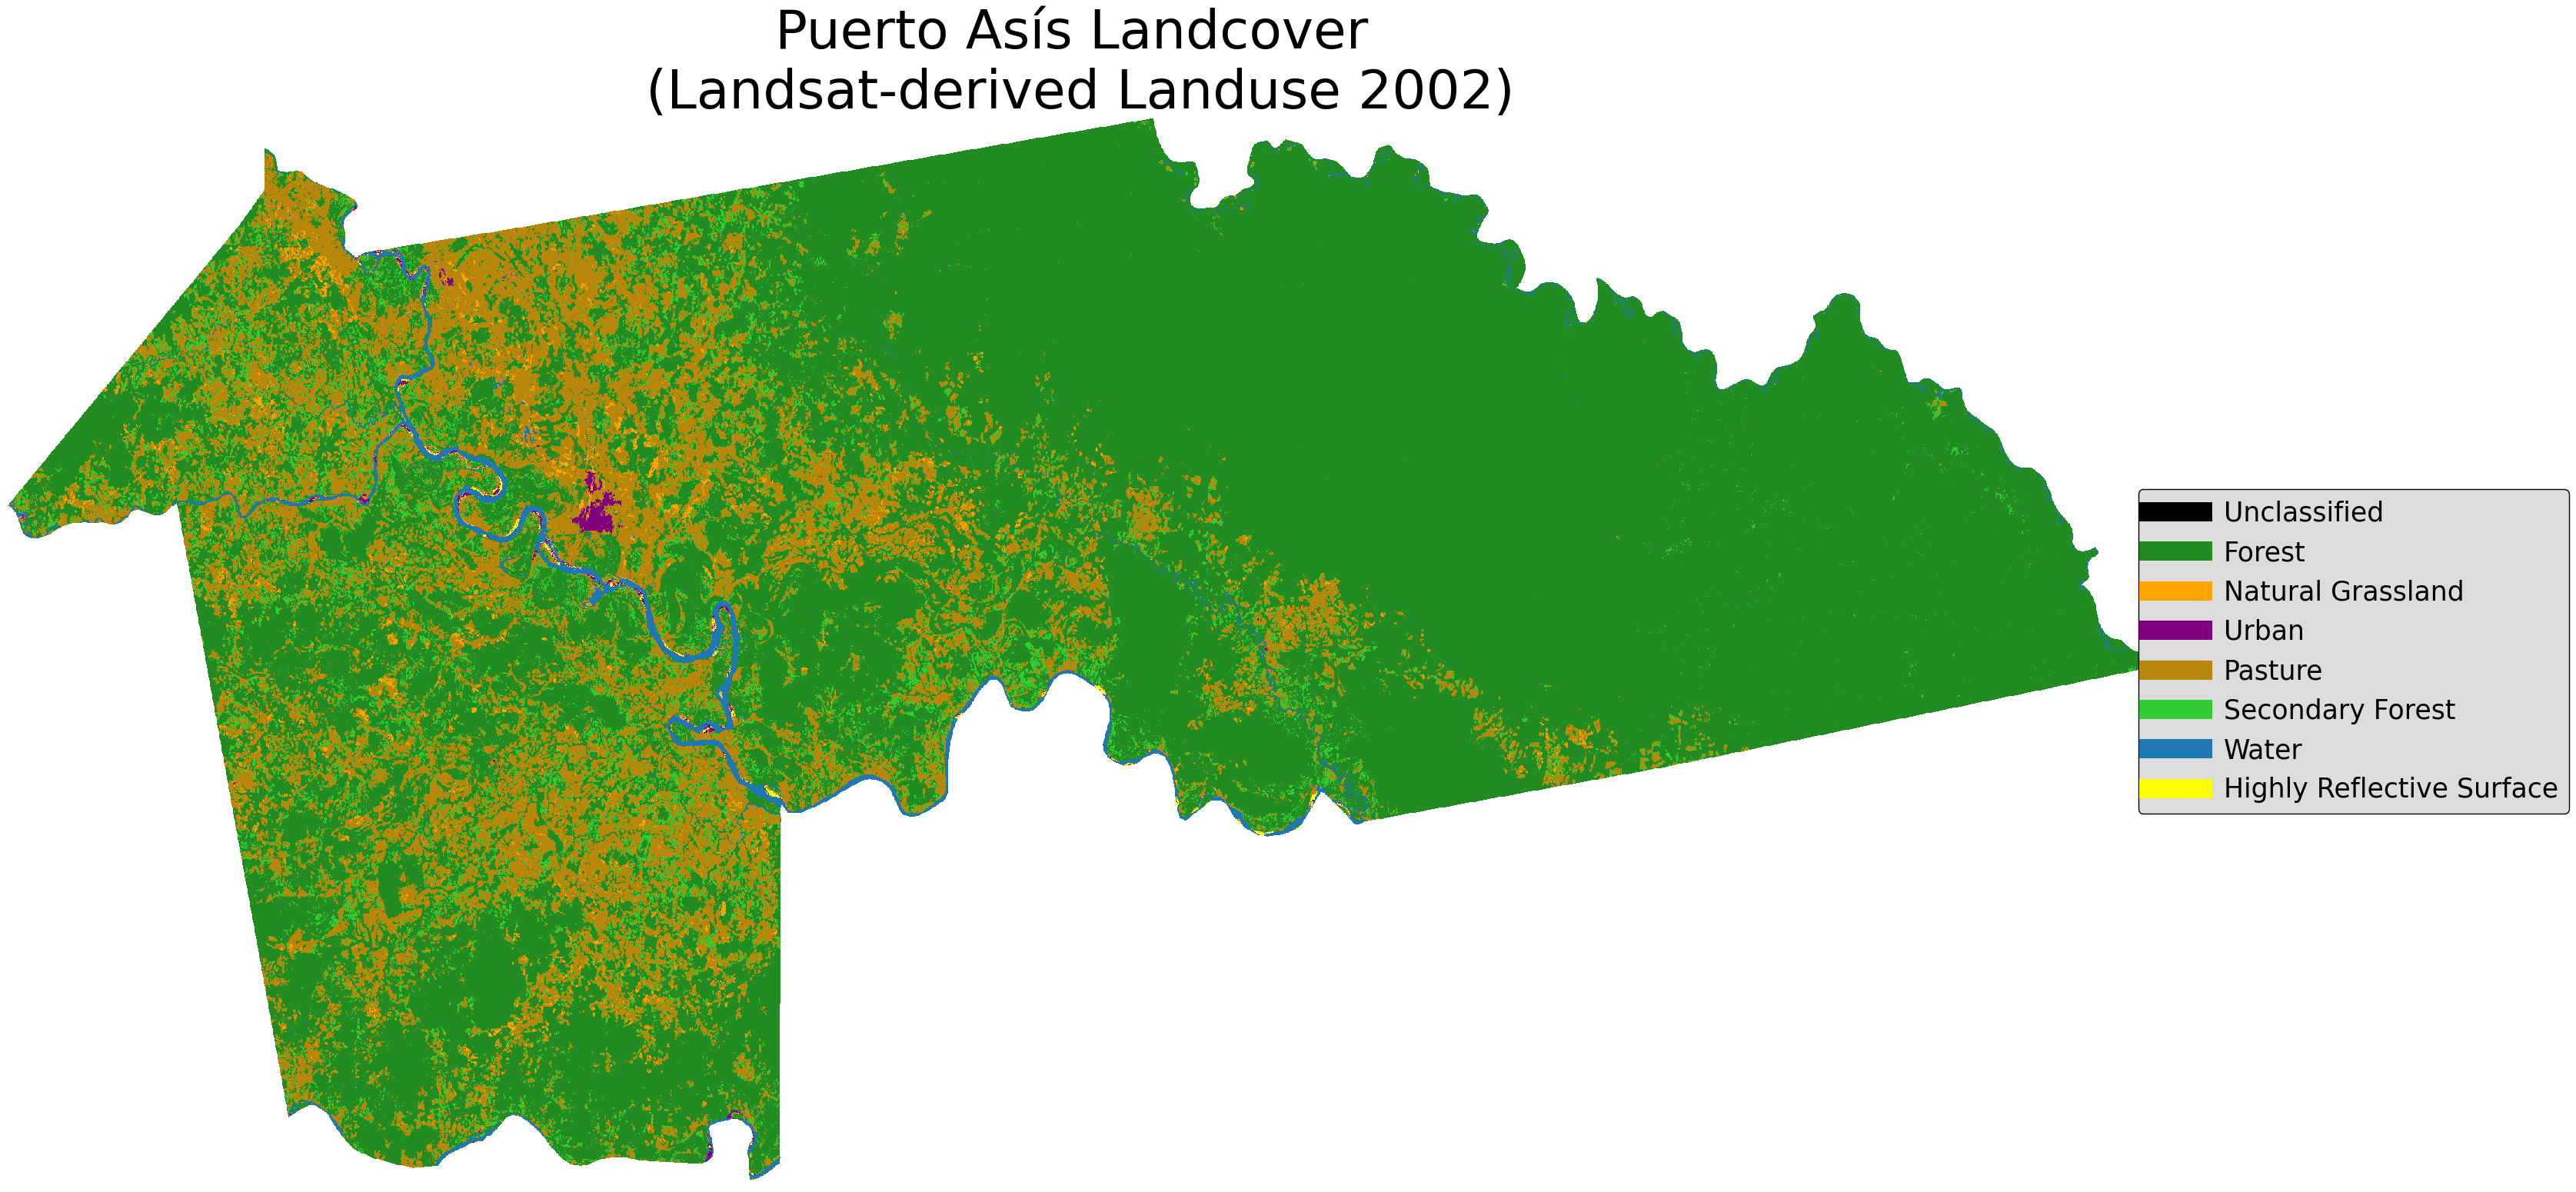

In [20]:
# Plot the raster clipped to Puerto Asís (2002)

fig, ax = plt.subplots(figsize=(36,18))

clipped_2002.where(clipped_2002!=clipped_2002.rio.nodata).plot(
    ax=ax,
    add_colorbar=False,
    cmap=cms_cmap,
    norm=norm)
plt.title("Puerto Asís Landcover \n(Landsat-derived Landuse 2002)",fontsize=50)

ax.axis('off')

ax.legend(handles=legend_elements,
          loc='right',
          fontsize='25',
          facecolor='gainsboro',
          edgecolor='black',
          framealpha=1.0,
          bbox_to_anchor=(1.2, 0.5))

plt.show()

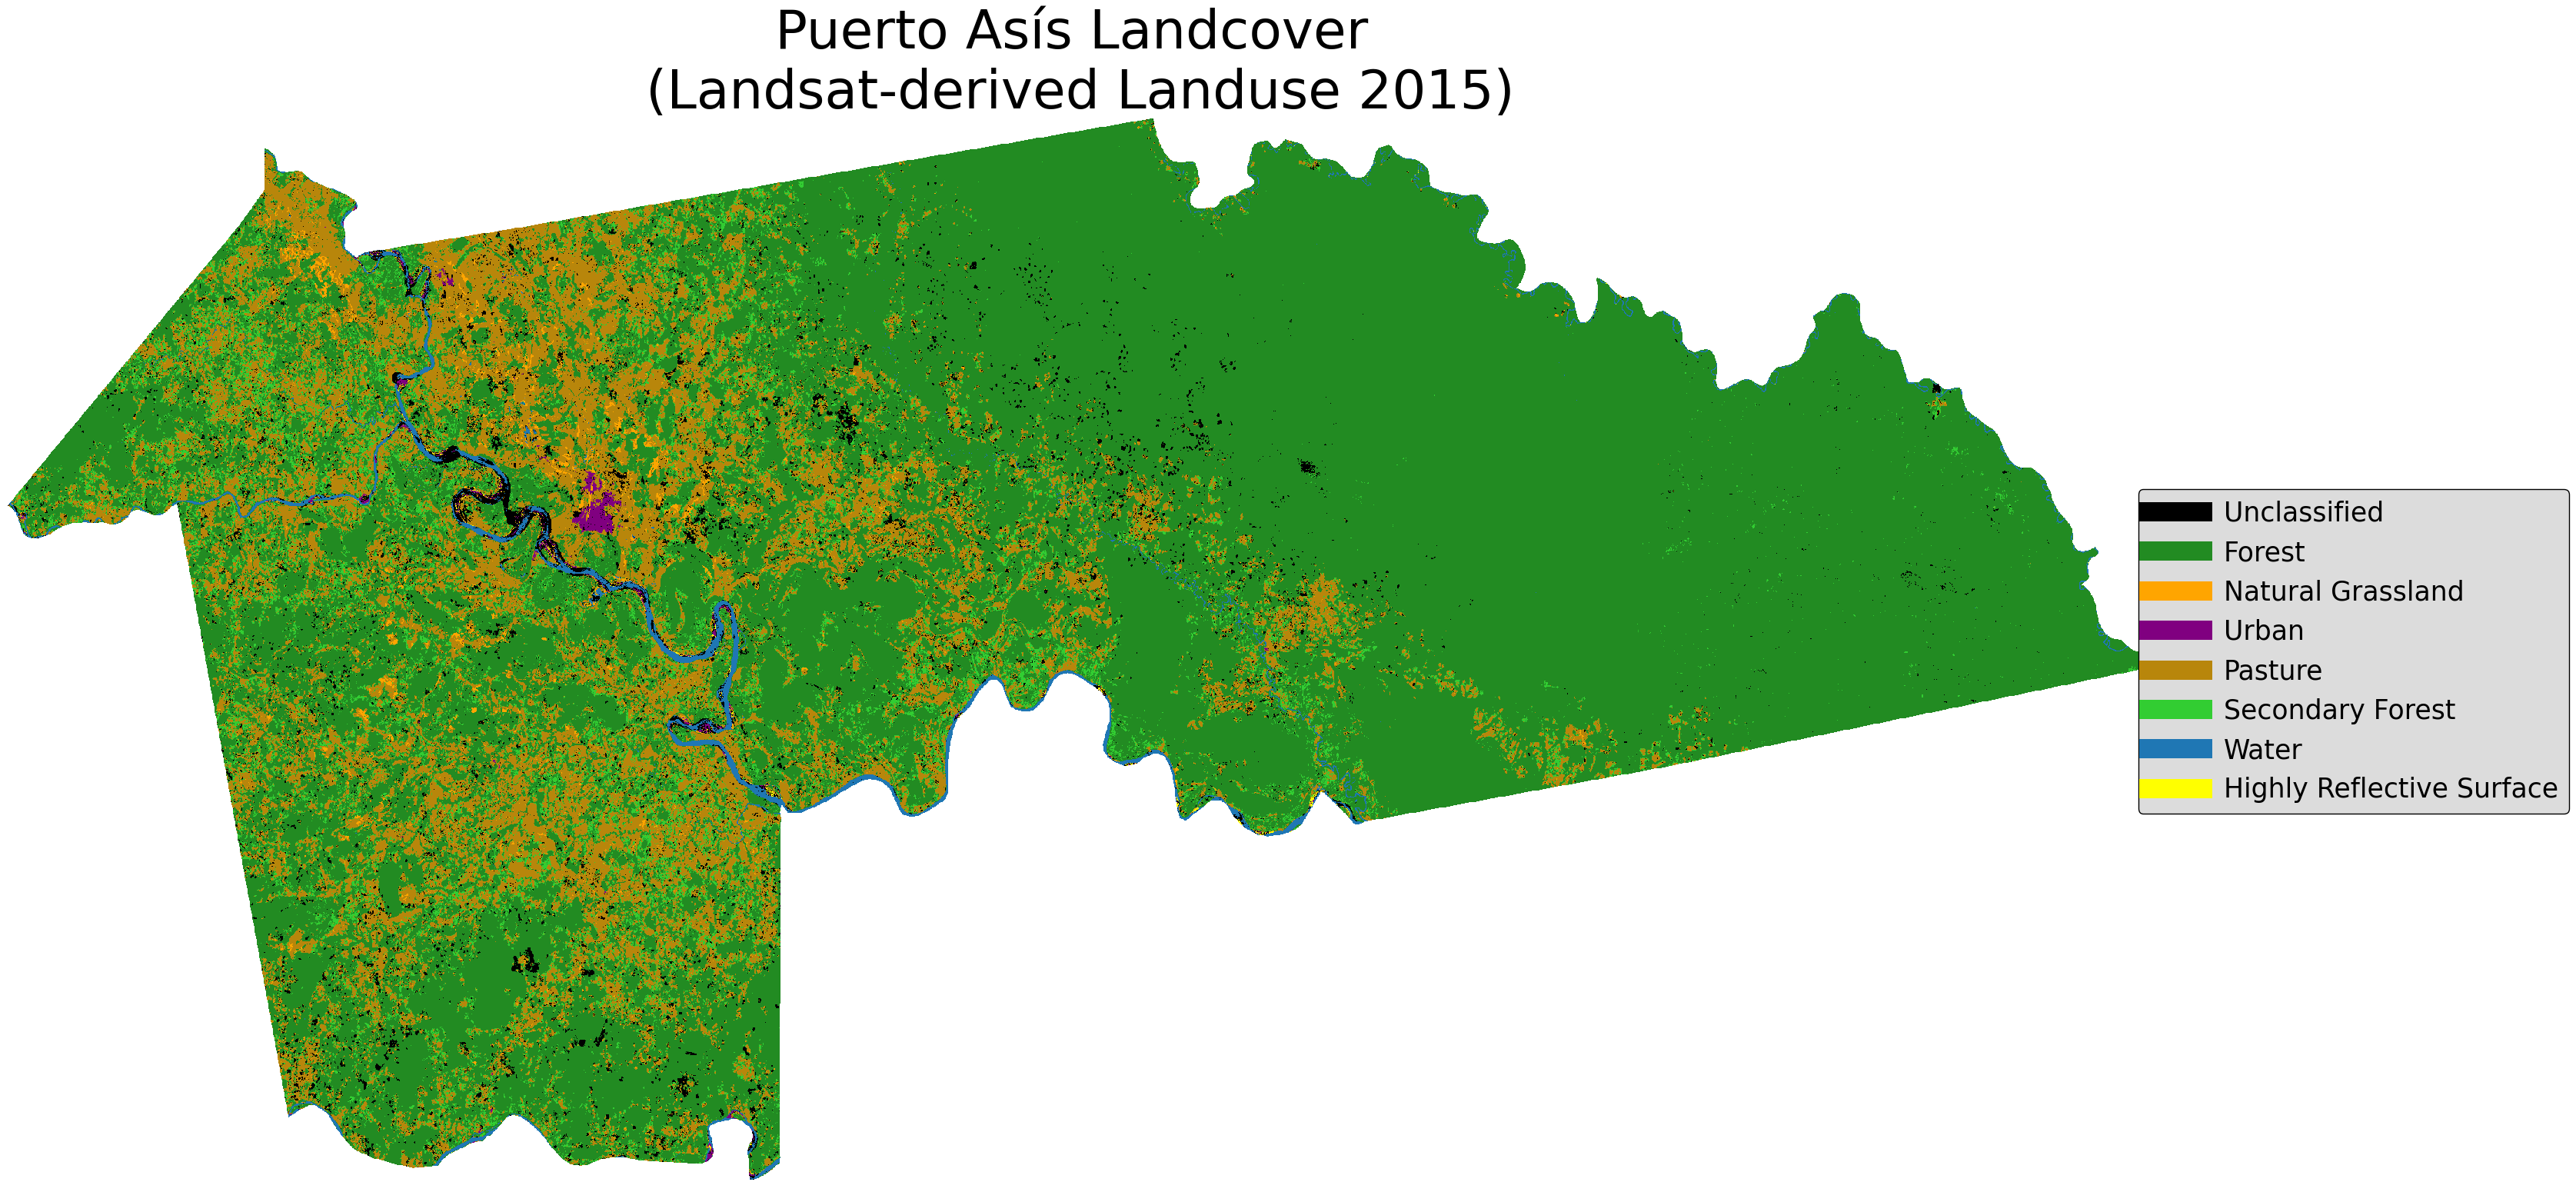

In [20]:
# Plot the raster clipped to Puerto Asís (2015)

fig, ax = plt.subplots(figsize=(36,18))

clipped_2015.where(clipped_2015!=clipped_2015.rio.nodata).plot(
    ax=ax,
    add_colorbar=False,
    cmap=cms_cmap,
    norm=norm)
plt.title("Puerto Asís Landcover \n(Landsat-derived Landuse 2015)",fontsize=50)

ax.axis('off')

ax.legend(handles=legend_elements,
          loc='right',
          fontsize='25',
          facecolor='gainsboro',
          edgecolor='black',
          framealpha=1.0,
          bbox_to_anchor=(1.2, 0.5))

plt.show()

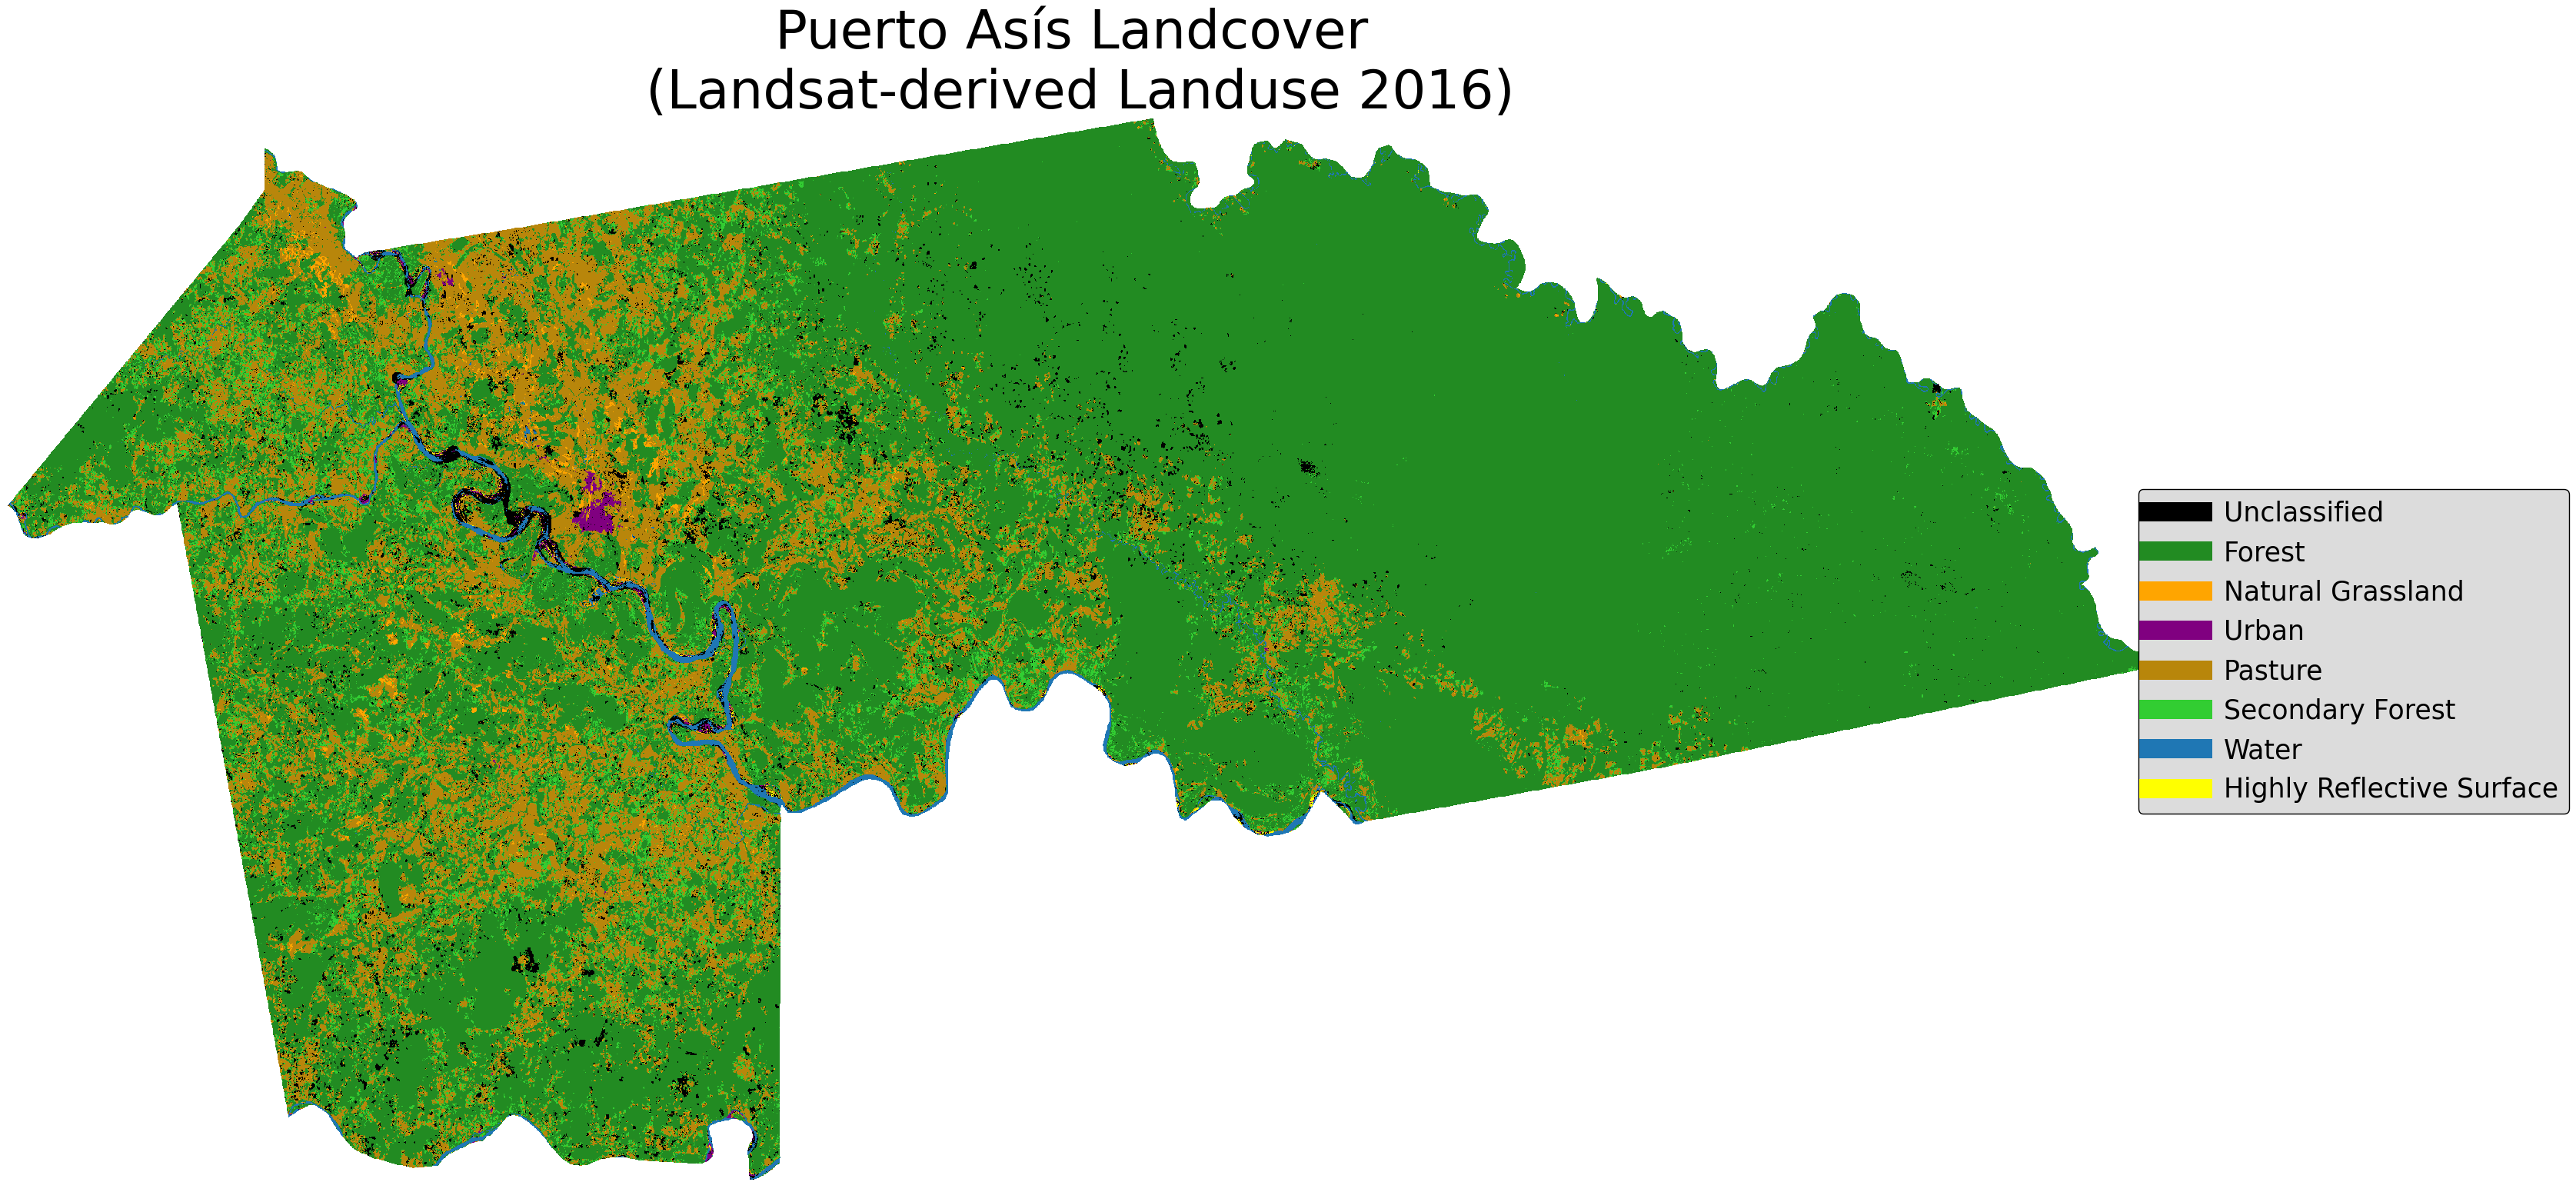

In [21]:
# Plot the raster clipped to Puerto Asís (2016)

fig, ax = plt.subplots(figsize=(36,18))

clipped_2016.where(clipped_2016!=clipped_2016.rio.nodata).plot(
    ax=ax,
    add_colorbar=False,
    cmap=cms_cmap,
    norm=norm)
plt.title("Puerto Asís Landcover \n(Landsat-derived Landuse 2016)",fontsize=50)

ax.axis('off')

ax.legend(handles=legend_elements,
          loc='right',
          fontsize='25',
          facecolor='gainsboro',
          edgecolor='black',
          framealpha=1.0,
          bbox_to_anchor=(1.2, 0.5))

plt.show()

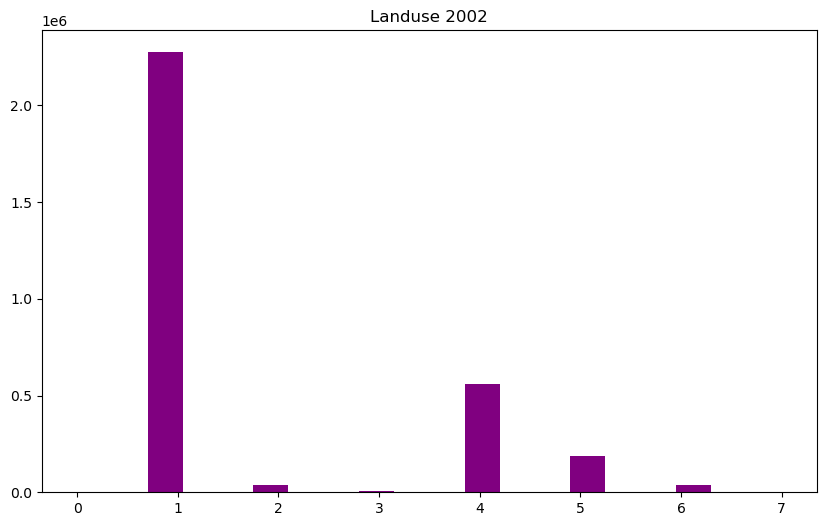

In [23]:
# Creating histograms of 2002 pixel counts
ep.hist(clipped_2002.values, title='Landuse 2002', figsize=(10,6))
plt.show()

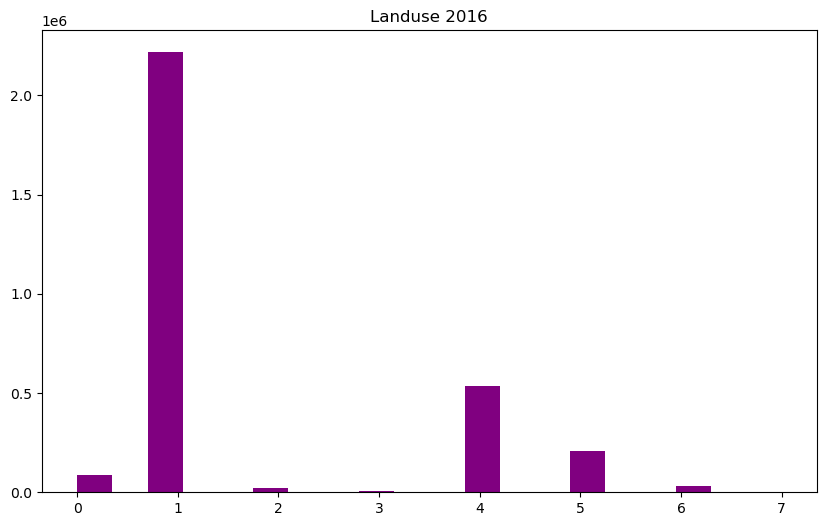

In [24]:
# Creating histograms of 2016 pixel counts
ep.hist(clipped_2016.values, title='Landuse 2016', figsize=(10,6))
plt.show()

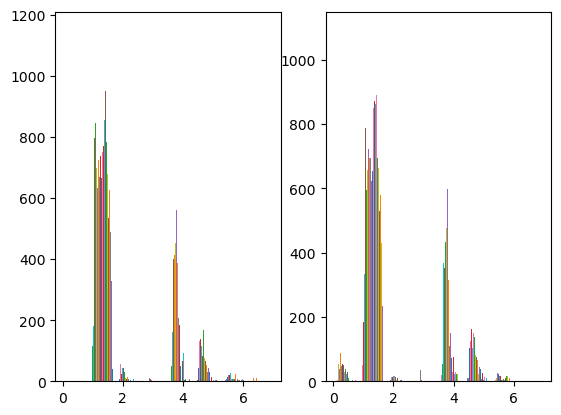

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True)
ax1.hist(clipped_2002.values, bins=8)
ax2.hist(clipped_2016.values, bins=8)
plt.show()